In [ ]:
! pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geopandas, google-colab, gspread-dataframe, holoviews, mizani, mlxtend, pandas-datareader, pandas-gbq, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# ! python -m spacy download en_core_web_trf
! python -m spacy download en_core_web_lg
# ! pip install spacy-transformers

2023-07-04 02:38:40.817830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 02:38:42.694589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-04 02:38:45.663217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 02:38:45.663642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
import pandas as pd
import numpy as np
import spacy
import spacy_transformers
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

## Data Cleaning



In [ ]:
df = pd.read_excel("Rating Scale - English.xlsx", skiprows=3)
df = df.loc[:129]
df.tail(3)

,Group,Subject,Stimuli,Unnamed: 3,Answer given (expl 1),Answer given 2 (expl 2),expl.1,Unnamed: 7,expl.2,Unnamed: 9,Unnamed: 10
127,B,13,8,key,racket,racket,4.0,NaN,4.0,NaN,NaN
128,B,13,9,lamp,home/house,home/house,4.0,NaN,4.0,NaN,NaN
129,B,13,10,leaf,racket,racket,3.0,NaN,3.0,NaN,NaN


### Rename Columns


In [ ]:
df = df.rename(columns={
    'Group': 'group',
    'Subject': 'subject',
    'Stimuli': 'stimuli',
    'Unnamed: 3': 'ground_truth',
    'Answer given (expl 1)': 'prediction1',
    'Answer given 2 (expl 2)': 'prediction2',
    'expl.1 ': 'manual_similarity_score1',
    'expl.2': 'manual_similarity_score2'
})
df.head(2)

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,Unnamed: 7,manual_similarity_score2,Unnamed: 9,Unnamed: 10
0,VI,1,1,face,face,face,5.0,NaN,5.0,NaN,NaN
1,VI,1,4,person/figure,little person,little child,5.0,NaN,5.0,NaN,NaN


In [ ]:
df = df[df.columns.drop(['Unnamed: 7', 'Unnamed: 9', 'Unnamed: 10'])]
df.head(2)

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,manual_similarity_score2
0,VI,1,1,face,face,face,5.0,5.0
1,VI,1,4,person/figure,little person,little child,5.0,5.0


### Rename Data

In [ ]:
for name, _ in df.groupby(["stimuli", "ground_truth"]):
  print(name)

(1, 'face')
(2, 'bottle')
(3, 'cup')
(3, 'cup/mug')
(4, 'person')
(4, 'person/figure')
(5, 'telephone')
(6, 'umbrella')
(7, 'scissors')
(7, 'scissors ')
(8, 'key')
(9, 'lamp')
(10, 'leaf ')
(11, 'apple')
(12, 'shoe')
(13, 'crutch/cane')
(15, 'flower')
(16, 'hand')


In [ ]:
df.loc[df.stimuli==2, 'ground_truth'] = 'bottle'
df.loc[df.stimuli==3, 'ground_truth'] = 'cup'
df.loc[df.stimuli==4, 'ground_truth'] = 'person'
df.loc[df.stimuli==7, 'ground_truth'] = 'scissors'

for name, _ in df.groupby(["stimuli", "ground_truth"]):
  print(name)

(1, 'face')
(2, 'bottle')
(3, 'cup')
(4, 'person')
(5, 'telephone')
(6, 'umbrella')
(7, 'scissors')
(8, 'key')
(9, 'lamp')
(10, 'leaf ')
(11, 'apple')
(12, 'shoe')
(13, 'crutch/cane')
(15, 'flower')
(16, 'hand')


In [ ]:
df.ground_truth.unique()

array(['face', 'person', 'umbrella', 'key', 'lamp', 'shoe', 'crutch/cane',
       'bottle', 'leaf ', 'cup', 'telephone', 'scissors', 'apple',
       'flower', 'hand'], dtype=object)

In [ ]:
sorted(df.subject.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
df.group.unique()

array(['VI', 'B', nan], dtype=object)

In [ ]:
df[df.group.isna()]

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,manual_similarity_score2
80,NaN,7,1,face,portrait of a person,portrait,5.0,5.0


In [ ]:
df[df.subject == 7]

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,manual_similarity_score2
80,NaN,7,1,face,portrait of a person,portrait,5.0,5.0
81,B,7,2,bottle,doll/puppet,dolly,3.0,3.0
82,B,7,3,cup,I don't know,NaN,0.0,0.0
83,B,7,4,person,little child,little child,5.0,5.0
84,B,7,6,umbrella,umbrella,umbrella,5.0,5.0
85,B,7,7,scissors,upside down scissor,upside down scissor,5.0,5.0
86,B,7,8,key,mirror,mirror,4.0,4.0
87,B,7,9,lamp,I don't know,glasses box,0.0,2.0
88,B,7,10,leaf,big leaf,leaf,5.0,5.0


In [ ]:
df.loc[df.subject == 7, 'group'] = 'B'
df.group.unique()

array(['VI', 'B'], dtype=object)

In [ ]:
df = df.fillna('')

## POS Tagging

In [ ]:
# nlp = spacy.load("en_core_web_trf")
nlp = spacy.load("en_core_web_lg")

# Extract nouns and adjectives
pos_tags = ["NOUN", "ADJ", "VERB", "PROPN"]
df["tokenized_ground_truth"] = df.ground_truth.apply(nlp)
df["tokenized_ground_truth"] = df.tokenized_ground_truth.apply(
    lambda x: [w for w in x if w.pos_ in pos_tags])

df["tokenized_prediction1"] = df.prediction1.apply(nlp)
df["tokenized_prediction1"] = df.tokenized_prediction1.apply(
    lambda x: [w for w in x if w.pos_ in pos_tags])

df["tokenized_prediction2"] = df.prediction2.apply(nlp)
df["tokenized_prediction2"] = df.tokenized_prediction2.apply(
    lambda x: [w for w in x if w.pos_ in pos_tags])

df

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,manual_similarity_score2,tokenized_ground_truth,tokenized_prediction1,tokenized_prediction2
0,VI,1,1,face,face,face,5.0,5.0,[face],[face],[face]
1,VI,1,4,person,little person,little child,5.0,5.0,[person],"[little, person]","[little, child]"
2,VI,1,6,umbrella,handle and some kind of bend/curve,umbrella,2.0,0.0,[umbrella],"[handle, kind, bend, curve]",[umbrella]
3,VI,1,8,key,I don't know,key,5.0,5.0,[key],[know],[key]
4,VI,1,9,lamp,I don't know,container,0.0,4.0,[lamp],[know],[container]
...,...,...,...,...,...,...,...,...,...,...,...
125,B,13,6,umbrella,umbrella,umbrella,5.0,5.0,[umbrella],[umbrella],[umbrella]
126,B,13,7,scissors,tree,tree,2.0,2.0,[scissors],[tree],[tree]
127,B,13,8,key,racket,racket,4.0,4.0,[key],[racket],[racket]
128,B,13,9,lamp,home/house,home/house,4.0,4.0,[lamp],"[home, house]","[home, house]"


## Word2Vec Exploration



In [ ]:
def debug_vector_distance(w1, w2):
  v1 = nlp(w1)[0].vector
  v2 = nlp(w2)[0].vector
  d = np.linalg.norm(v1-v2, ord=2)
  print(f"The distance between '{w1}' and '{w2}' is {d:.2f}")

In [ ]:
facial_features = ["person", "body", "eyes", "nose", "ears", "skin", "hair"]
for w2 in facial_features:
  debug_vector_distance("face", w2)


The distance between 'face' and 'person' is 64.66
The distance between 'face' and 'body' is 71.91
The distance between 'face' and 'eyes' is 60.76
The distance between 'face' and 'nose' is 60.40
The distance between 'face' and 'ears' is 62.75
The distance between 'face' and 'skin' is 76.50
The distance between 'face' and 'hair' is 74.61


In [ ]:
facial_features = ["direction", "head", "go"]
for w2 in facial_features:
  debug_vector_distance("face", w2)

The distance between 'face' and 'direction' is 68.73
The distance between 'face' and 'head' is 63.03
The distance between 'face' and 'go' is 107.66


In [ ]:
facial_features = df.tokenized_ground_truth
visited = set()
for words in facial_features:
  for word in words:
    if str(word) in visited:
      continue

    debug_vector_distance("face", str(word))
    visited.add(str(word))

The distance between 'face' and 'face' is 0.00
The distance between 'face' and 'person' is 64.66
The distance between 'face' and 'umbrella' is 62.69
The distance between 'face' and 'key' is 93.99
The distance between 'face' and 'lamp' is 73.81
The distance between 'face' and 'shoe' is 71.38
The distance between 'face' and 'crutch' is 62.22
The distance between 'face' and 'cane' is 71.06
The distance between 'face' and 'bottle' is 64.76
The distance between 'face' and 'leaf' is 77.85
The distance between 'face' and 'cup' is 87.36
The distance between 'face' and 'telephone' is 66.83
The distance between 'face' and 'scissors' is 61.40
The distance between 'face' and 'apple' is 68.25
The distance between 'face' and 'flower' is 67.87
The distance between 'face' and 'hand' is 65.84


## Explore Vector Visualizations


(16, 300)


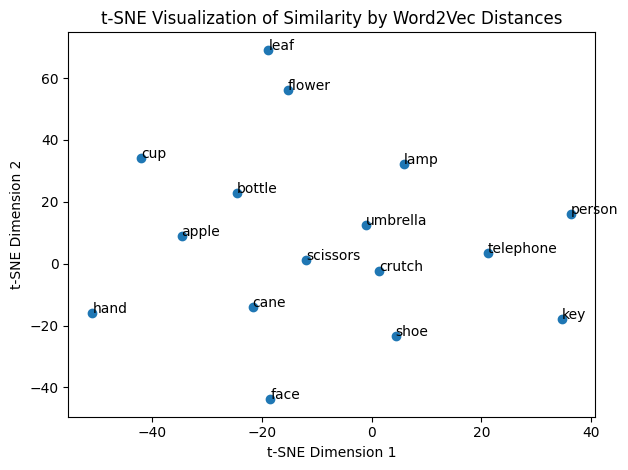

In [ ]:
facial_features = df.tokenized_ground_truth

words = {str(w) for words in df.tokenized_ground_truth for w in words}
words = [nlp(w)[0] for w in words]
word_vector = np.array([w.vector for w in words])
X = word_vector
print(X.shape)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(X)

x, y = X_embedded.T
plt.scatter(x, y)

for i, (x, y) in enumerate(X_embedded):
  plt.text(x, y, str(words[i]))

plt.title("t-SNE Visualization of Similarity by Word2Vec Distances")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig("word2vec_ground_truth_distances.png")

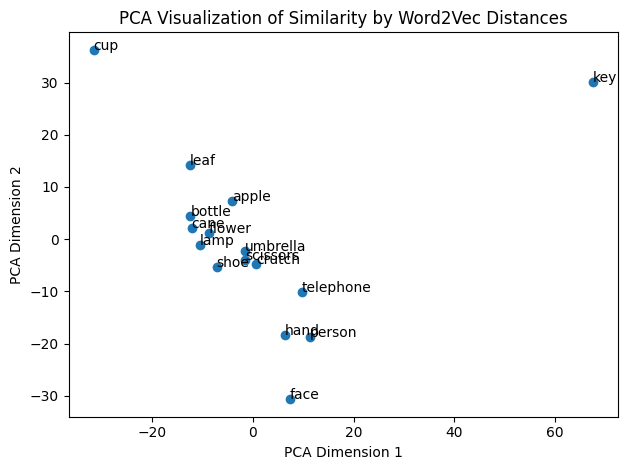

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
X_embedded = pca.transform(X)

x, y = X_embedded.T
plt.scatter(x, y)
for i, (x, y) in enumerate(X_embedded):
  plt.text(x, y, str(words[i]))

plt.title("PCA Visualization of Similarity by Word2Vec Distances")
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.tight_layout()
plt.savefig("pca_word2vec_ground_truth_distances.png")

## Calculate Closest Distance Vectors for Each

In [ ]:
def calculate_closest_distance_vectors(s1, s2):
  nearest = -1
  for w1 in s1:
    v1 = w1.vector
    for w2 in s2:
      v2 = w2.vector
      d = np.linalg.norm(v1-v2, ord=2)
      if nearest == -1 or d < nearest:
        nearest = d

  return nearest

for idx, row in df.iterrows():
  df.loc[idx, 'distance_predication1'] = calculate_closest_distance_vectors(
      row.tokenized_ground_truth, row.tokenized_prediction1)

  df.loc[idx, 'distance_predication2'] = calculate_closest_distance_vectors(
      row.tokenized_ground_truth, row.tokenized_prediction2)


In [ ]:
df

,group,subject,stimuli,ground_truth,prediction1,prediction2,manual_similarity_score1,manual_similarity_score2,tokenized_ground_truth,tokenized_prediction1,tokenized_prediction2,distance_predication1,distance_predication2
0,VI,1,1,face,face,face,5.0,5.0,[face],[face],[face],0.000000,0.000000
1,VI,1,4,person,little person,little child,5.0,5.0,[person],"[little, person]","[little, child]",0.000000,47.189495
2,VI,1,6,umbrella,handle and some kind of bend/curve,umbrella,2.0,0.0,[umbrella],"[handle, kind, bend, curve]",[umbrella],44.875172,0.000000
3,VI,1,8,key,I don't know,key,5.0,5.0,[key],[know],[key],88.529228,0.000000
4,VI,1,9,lamp,I don't know,container,0.0,4.0,[lamp],[know],[container],70.088333,55.279503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,B,13,6,umbrella,umbrella,umbrella,5.0,5.0,[umbrella],[umbrella],[umbrella],0.000000,0.000000
126,B,13,7,scissors,tree,tree,2.0,2.0,[scissors],[tree],[tree],64.222961,64.222961
127,B,13,8,key,racket,racket,4.0,4.0,[key],[racket],[racket],82.567841,82.567841
128,B,13,9,lamp,home/house,home/house,4.0,4.0,[lamp],"[home, house]","[home, house]",64.835320,64.835320


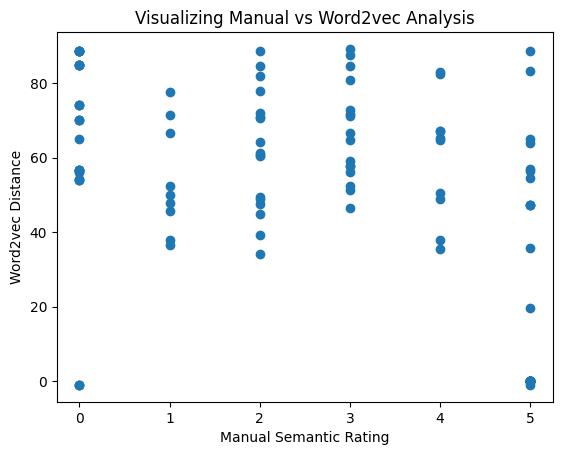

In [ ]:
plt.scatter(df.manual_similarity_score1, df.distance_predication1)
plt.title("Visualizing Manual vs Word2vec Analysis")
plt.ylabel("Word2vec Distance")
plt.xlabel("Manual Semantic Rating")
plt.savefig("manual_vs_word2vec_scatter.png")

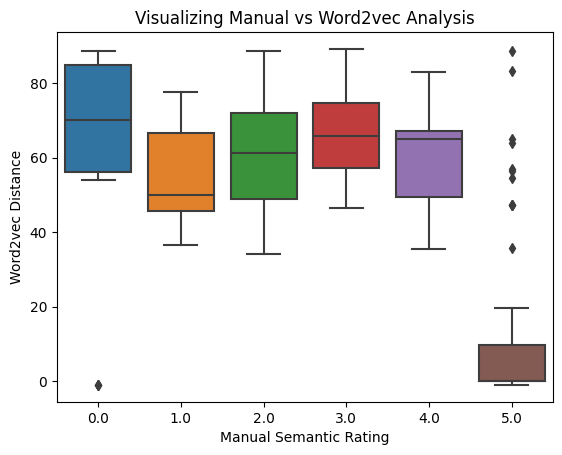

In [ ]:
sns.boxplot(data=df, x='manual_similarity_score1', y='distance_predication1')
plt.title("Visualizing Manual vs Word2vec Analysis")
plt.ylabel("Word2vec Distance")
plt.xlabel("Manual Semantic Rating")
plt.savefig("manual_vs_word2vec_box.png")

In [ ]:
df.groupby('manual_similarity_score1').agg({'distance_predication1': 'mean'})

,distance_predication1
manual_similarity_score1,
0.0,64.717690
1.0,54.007055
2.0,62.177763
3.0,66.873625
4.0,60.318269
5.0,14.136940


In [ ]:
df.groupby('manual_similarity_score2').agg({'distance_predication2': 'mean'})

,distance_predication2
manual_similarity_score2,
0.0,37.325698
1.0,61.919573
2.0,60.003290
3.0,64.708779
4.0,64.654324
5.0,12.657408


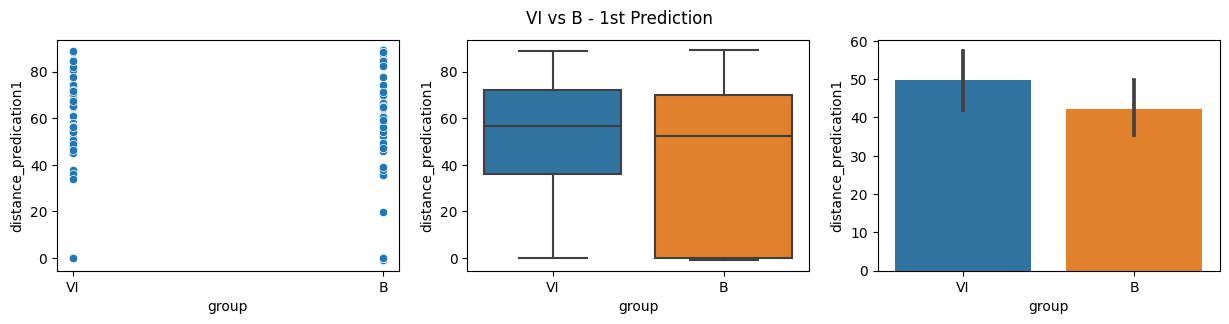

In [ ]:
plt.figure(figsize=(15, 3))
gs = plt.GridSpec(1, 3)
ax = plt.subplot(gs[0])
sns.scatterplot(data=df, y='distance_predication1', x='group', ax=ax)

ax = plt.subplot(gs[1])
sns.boxplot(data=df, y='distance_predication1', x='group', ax=ax)

ax = plt.subplot(gs[2])
sns.barplot(data=df, y='distance_predication1', x='group', ax=ax)

plt.suptitle("VI vs B - 1st Prediction")
plt.savefig("prediction1.png")

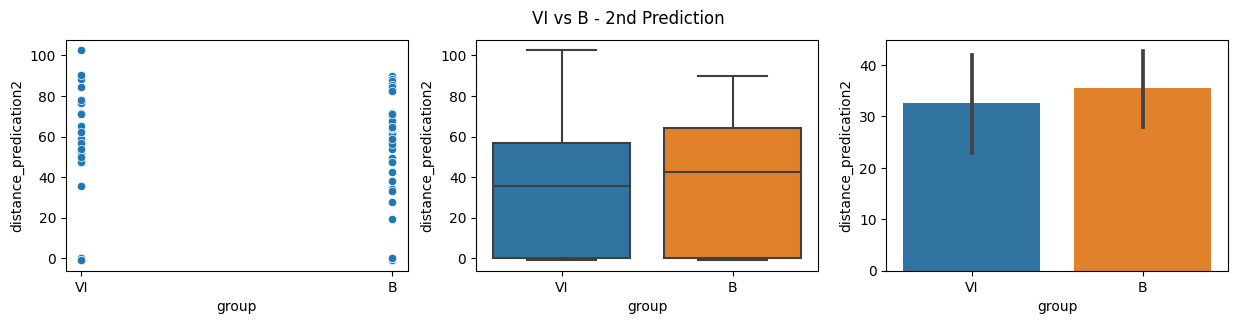

In [ ]:
plt.figure(figsize=(15, 3))
gs = plt.GridSpec(1, 3)
ax = plt.subplot(gs[0])
sns.scatterplot(data=df, y='distance_predication2', x='group', ax=ax)

ax = plt.subplot(gs[1])
sns.boxplot(data=df, y='distance_predication2', x='group', ax=ax)

ax = plt.subplot(gs[2])
sns.barplot(data=df, y='distance_predication2', x='group', ax=ax)

plt.suptitle("VI vs B - 2nd Prediction")
plt.savefig("prediction2.png")


In [ ]:
df.to_csv("results.csv")